In [1]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from rff.layers import GaussianEncoding #pip install random-fourier-features-pytorch
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, recall_score, confusion_matrix
from sklearn.preprocessing import StandardScaler, LabelEncoder
import os
import optuna
from optuna.trial import TrialState

/home/cscadmin/miniconda3/envs/torch-env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Run regardless if you do or do not have GPU so all tensors are moved to right location later on
if torch.cuda.is_available():
    device_in_use = torch.device("cuda")
    print("GPU is available and being used")
else:
    device_in_use = torch.device("cpu")
    print("GPU is not available, using CPU instead")

GPU is available and being used


# LOAD AND PROCESS DATA
**EXAMPLE WITH COVTYPE DATASET**
1. Standardize or perform quantile transformations to numerical/continuous features.
1. Wrap with Dataset and Dataloader.

In [4]:
df_train = pd.read_csv('/home/cscadmin/CyberResearch/CAT-Transformer/datasets/covertype/train.csv')
df_test = pd.read_csv('/home/cscadmin/CyberResearch/CAT-Transformer/datasets/covertype/test.csv')
df_val = pd.read_csv('/home/cscadmin/CyberResearch/CAT-Transformer/datasets/covertype/validation.csv') #READ FROM RIGHT SPOT

# df_train = pd.read_csv(r'C:\Users\smbm2\projects\CAT-Transformer\datasets\covertype\train.csv')
# df_test = pd.read_csv(r'C:\Users\smbm2\projects\CAT-Transformer\datasets\covertype\test.csv')
# df_val = pd.read_csv(r'C:\Users\smbm2\projects\CAT-Transformer\datasets\covertype\validation.csv') #READ FROM RIGHT SPOT

#Take a look at what the datasets look like initially to get an idea
df_train

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Cover_Type
0,2909,275,13,30,9,1932,185,243,197,1150,...,0,1,0,0,0,0,0,0,0,1
1,3185,285,19,210,75,153,163,236,211,571,...,0,0,0,0,0,0,0,0,0,0
2,2606,324,29,446,222,641,135,196,193,1082,...,0,0,0,0,0,0,0,0,0,1
3,2629,338,18,150,56,1214,177,211,171,832,...,0,0,0,0,0,0,0,0,0,1
4,2868,6,10,309,31,1048,208,222,150,2733,...,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
371842,3182,70,13,362,40,2992,234,214,109,4336,...,0,0,0,0,0,0,0,0,0,0
371843,3172,156,29,716,291,1154,237,228,98,2837,...,0,0,0,0,0,0,0,0,0,0
371844,3153,287,17,335,41,1298,171,237,205,2045,...,1,0,0,0,0,0,0,0,0,0
371845,3065,348,21,124,19,4725,177,202,159,624,...,0,0,0,0,0,0,0,0,0,1


In [5]:
#Take a look at the feature names
df_train.columns

Index(['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology',
       'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways',
       'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm',
       'Horizontal_Distance_To_Fire_Points', 'Wilderness_Area1',
       'Wilderness_Area2', 'Wilderness_Area3', 'Wilderness_Area4',
       'Soil_Type1', 'Soil_Type2', 'Soil_Type3', 'Soil_Type4', 'Soil_Type5',
       'Soil_Type6', 'Soil_Type7', 'Soil_Type8', 'Soil_Type9', 'Soil_Type10',
       'Soil_Type11', 'Soil_Type12', 'Soil_Type13', 'Soil_Type14',
       'Soil_Type15', 'Soil_Type16', 'Soil_Type17', 'Soil_Type18',
       'Soil_Type19', 'Soil_Type20', 'Soil_Type21', 'Soil_Type22',
       'Soil_Type23', 'Soil_Type24', 'Soil_Type25', 'Soil_Type26',
       'Soil_Type27', 'Soil_Type28', 'Soil_Type29', 'Soil_Type30',
       'Soil_Type31', 'Soil_Type32', 'Soil_Type33', 'Soil_Type34',
       'Soil_Type35', 'Soil_Type36', 'Soil_Type37', 'Soil_Type38',
       'Soil_Type39', 'Soil_Type40

In [6]:
cont_columns = ['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology',
       'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways',
       'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm',
       'Horizontal_Distance_To_Fire_Points', 'Wilderness_Area1',
       'Wilderness_Area2', 'Wilderness_Area3', 'Wilderness_Area4',
       'Soil_Type1', 'Soil_Type2', 'Soil_Type3', 'Soil_Type4', 'Soil_Type5',
       'Soil_Type6', 'Soil_Type7', 'Soil_Type8', 'Soil_Type9', 'Soil_Type10',
       'Soil_Type11', 'Soil_Type12', 'Soil_Type13', 'Soil_Type14',
       'Soil_Type15', 'Soil_Type16', 'Soil_Type17', 'Soil_Type18',
       'Soil_Type19', 'Soil_Type20', 'Soil_Type21', 'Soil_Type22',
       'Soil_Type23', 'Soil_Type24', 'Soil_Type25', 'Soil_Type26',
       'Soil_Type27', 'Soil_Type28', 'Soil_Type29', 'Soil_Type30',
       'Soil_Type31', 'Soil_Type32', 'Soil_Type33', 'Soil_Type34',
       'Soil_Type35', 'Soil_Type36', 'Soil_Type37', 'Soil_Type38',
       'Soil_Type39', 'Soil_Type40']
target = ['Cover_Type']

#CHECKING TO MAKE SURE YOUR LIST IS CORRECT (NO NEED TO TOUCH)
yourlist = cont_columns + target
yourlist.sort()
oglist = list(df_train.columns)
oglist.sort()

assert(yourlist == oglist), "You may of spelled feature name wrong or you forgot to put on of them in the list"

In [7]:
#Getting the number of classes in your classification target
target_classes = [max(len(df_train[target].value_counts()), len(df_val[target].value_counts()),len(df_test[target].value_counts()))]
target_classes

[7]

In [8]:
# Create a StandardScaler and fit it to the cont features
scaler = StandardScaler()
scaler.fit(df_train[cont_columns])

# Transform the training, test, and validation datasets
df_train[cont_columns] = scaler.transform(df_train[cont_columns])
df_test[cont_columns] = scaler.transform(df_test[cont_columns])
df_val[cont_columns] = scaler.transform(df_val[cont_columns])

In [9]:
class SingleTaskDataset(Dataset):
    def __init__(self, df : pd.DataFrame, num_columns,task1_column):
        self.n = df.shape[0]
        
        self.task1_labels = df[task1_column].astype(np.int64).values

        self.num = df[num_columns].astype(np.float32).values


    def __len__(self):
        return self.n
    
    def __getitem__(self, idx):
        # Retrieve features and labels from the dataframe using column names
        num_features = self.num[idx]
        labels_task1 = self.task1_labels[idx]

        return num_features, labels_task1

#Wrapping in Dataset
train_dataset = SingleTaskDataset(df_train, cont_columns, 'Cover_Type')
val_dataset = SingleTaskDataset(df_val, cont_columns, 'Cover_Type')
test_dataset = SingleTaskDataset(df_test, cont_columns, 'Cover_Type')

#This is a hyperparameter that is not tuned. Maybe mess with what makes sense here
#Also try looking to see what other papers have done
batch_size = 256

# Wrapping with DataLoader for easy batch extraction
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

# MODEL AND HELPERS

1. All you should have to do is interact with Classifier()

In [10]:
# each task loss is scaled by its own learnable parameter, then regularization is applied 
class UncertaintyLoss(nn.Module):
    def __init__(self, num_tasks):
        super(UncertaintyLoss, self).__init__()
        self.num_tasks = num_tasks

        self.loss_fns = [nn.CrossEntropyLoss() for x in range(num_tasks)] 

    def forward(self, predictions, labels_task1):

        #task 1
        target = labels_task1
        prediction = predictions[0]
        loss_fn = self.loss_fns[0]
        task_loss = loss_fn(prediction, target)
        
        return task_loss
    
#All layers of the model
class MultiHeadAttention(nn.Module):
    def __init__(self, embed_size, heads):
        super(MultiHeadAttention, self).__init__()

        self.embed_size = embed_size
        self.heads = heads
        self.head_dim = embed_size // heads
        assert(self.head_dim * heads == embed_size), "Embed size needs to be div by heads"
        self.values = nn.Linear(self.head_dim, self.head_dim, bias=False)
        self.keys =nn.Linear(self.head_dim, self.head_dim, bias=False)
        self.queries = nn.Linear(self.head_dim, self.head_dim, bias=False)
        self.fc_out = nn.Linear(heads*self.head_dim, embed_size)


    def forward(self, values, keys, query):
        N = query.shape[0]
        value_len, key_len, query_len = values.shape[1], keys.shape[1], query.shape[1]

        values = values.reshape(N, value_len, self.heads, self.head_dim)
        keys = keys.reshape(N, key_len, self.heads, self.head_dim)
        queries = query.reshape(N, query_len, self.heads, self.head_dim)

        values = self.values(values)
        keys = self.keys(keys)
        queries = self.queries(queries)

        energy = torch.einsum("nqhd,nkhd->nhqk", [queries, keys])

        attention = torch.softmax(energy / (self.embed_size ** (1/2)), dim=3) #(batch_size, head_dim, #query_embeddings, #key_embeddings)

        # Calculate simplified attention scores
        avg_attention = attention.mean(dim=0)  # Average across batches
        # print("batch average", avg_attention.shape)
        avg_attention = avg_attention.mean(dim=0).squeeze(dim=0)
        # print("head average", avg_attention.shape)

        out = torch.einsum("nhql,nlhd->nqhd", [attention, values]).reshape(N, query_len, self.heads*self.head_dim) #(batch_size, n_features, embed_size)
        out = self.fc_out(out)

        return out, avg_attention
    
class TransformerBlock(nn.Module):
    def __init__(self, embed_size, heads, dropout, forward_expansion, pre_norm_on):
        super(TransformerBlock, self).__init__()

        self.pre_norm_on = pre_norm_on
        if self.pre_norm_on:
            self.pre_norm = nn.LayerNorm(embed_size)
        self.attention = MultiHeadAttention(embed_size, heads)
        self.norm1 = nn.LayerNorm(embed_size)
        self.norm2 = nn.LayerNorm(embed_size)

        self.feed_forward = nn.Sequential(nn.Linear(embed_size, forward_expansion*embed_size),
                                          nn.ReLU(),
                                          nn.Linear(forward_expansion*embed_size, embed_size)
                                          )
        self.dropout = nn.Dropout(dropout)

    def forward(self,value,key,query):
        if self.pre_norm_on:
            query = self.pre_norm(query)
            key = self.pre_norm(key)
            value = self.pre_norm(value)
            
        attention, avg_attention = self.attention(value, key, query)
        x = self.dropout(self.norm1(attention + query))
        forward = self.feed_forward(x)
        out = self.dropout(self.norm2(forward + x))
        return out, avg_attention
    
class DecoderBlock(nn.Module):
    def __init__(self, embed_size, heads, forward_expansion, dropout, pre_norm_on):
        super(DecoderBlock, self).__init__()

        self.attention = MultiHeadAttention(embed_size, heads)
        self.norm = nn.LayerNorm(embed_size)
        self.transformer_block = TransformerBlock(embed_size, heads, dropout, forward_expansion, pre_norm_on)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, value, key):
        out, avg_attention = self.transformer_block(value, key, x)

        return out, avg_attention

class Decoder(nn.Module):
    def __init__(self,
                 embed_size,
                 num_layers,
                 heads,
                 forward_expansion,
                 decoder_dropout,
                 pre_norm_on
    ):
        super(Decoder, self).__init__()

        self.layers = nn.ModuleList(
                [
                    DecoderBlock(
                        embed_size,
                        heads,
                        dropout=decoder_dropout,
                        forward_expansion=forward_expansion,
                        pre_norm_on=pre_norm_on
                    )
                    for _ in range(num_layers)
                ]
            )
        self.avg_attention = None

    def forward(self, class_embed, context):
        for layer in self.layers:
            # x is the classification embedding (CLS Token)
            # context are the feature embeddings that will be used as key and value
            x, self.avg_attention = layer(class_embed, context, context)
  
        return x 

class Embeddings(nn.Module):
    def __init__(self, sigma, embed_size, input_size, embedding_dropout, n_features, num_target_labels, rff_on):
        super(Embeddings, self).__init__()

        self.rff_on = rff_on

        if self.rff_on:
            self.rffs = nn.ModuleList([GaussianEncoding(sigma=sigma, input_size=input_size, encoded_size=embed_size//2) for _ in range(n_features)])
            self.dropout = nn.Dropout(embedding_dropout)
            self.mlp_in = embed_size
        else:
            self.mlp_in = input_size

        self.embeddings = nn.ModuleList([nn.Linear(in_features=self.mlp_in, out_features=embed_size) for _ in range(n_features)])

        # Classifcation Embeddings for each target label
        self.target_label_embeddings = nn.ModuleList([nn.Embedding(1, embed_size) for _ in range(num_target_labels)])


    def forward(self, x):
        x = x.unsqueeze(2) #(batch_size, n_features) -> (batch_size, n_features, 1)
        rff_vectors = []
        if self.rff_on:
            for i, r in enumerate(self.rffs):
                input = x[:,i,:]
                out = r(input)
                rff_vectors.append(out)
        
            x = torch.stack(rff_vectors, dim=1)
        
        embeddings = []
        for i, e in enumerate(self.embeddings):
            goin_in = x[:,i,:]
            goin_out = e(goin_in)
            embeddings.append(goin_out)

        target_label_embeddings_ = []
        for e in self.target_label_embeddings:
            input = torch.tensor([0], device=x.device)
            temp = e(input)
            temp = temp.repeat(x.size(0), 1)
            tmep = temp.unsqueeze(1)
            target_label_embeddings_.append(temp)

        class_embeddings = torch.stack(target_label_embeddings_, dim=1)

        context = torch.stack(embeddings, dim=1)

        return class_embeddings, context

class classificationHead(nn.Module):
    def __init__(self, embed_size, dropout, mlp_scale_classification, num_target_classes):
        super(classificationHead, self).__init__()
        
        #flattening the embeddings out so each sample in batch is represented with a 460 dimensional vector
        self.input = embed_size
        self.lin1 = nn.Linear(self.input, mlp_scale_classification*self.input)
        self.drop = nn.Dropout(dropout)
        self.lin2 = nn.Linear(mlp_scale_classification*self.input, mlp_scale_classification*self.input)
        self.lin3 = nn.Linear(mlp_scale_classification*self.input, self.input)
        self.lin4 = nn.Linear(self.input, num_target_classes)
        self.relu = nn.ReLU()
        self.initialize_weights()

    def initialize_weights(self): #he_initialization.
        torch.nn.init.kaiming_normal_(self.lin1.weight, nonlinearity='relu')
        torch.nn.init.zeros_(self.lin1.bias)

        torch.nn.init.kaiming_normal_(self.lin3.weight, nonlinearity='relu')
        torch.nn.init.zeros_(self.lin3.bias)

    def forward(self, x):

        x= torch.reshape(x, (-1, self.input))

        x = self.lin1(x)
        x = self.relu(x)
        x = self.drop(x)
        x = self.lin2(x)
        x = self.relu(x)
        x = self.drop(x)
        x = self.lin3(x)
        x = self.relu(x)
        x = self.drop(x)
        x = self.lin4(x)
  
        return x


# DEFAULT PARAMETERS SET UP FOR VPN DATASET. BE CAREFUL AND MAKE SURE YOU SET THEM UP HOW YOU WANT.
class Classifier(nn.Module):
    def __init__(self, 
                 rff_on = False,
                 sigma=4,
                 embed_size=20,
                 input_size=1,
                 embedding_dropout = 0,
                 n_features=23, # YOU WILL PROBABLY NEED TO CHANGE
                 num_layers=1,
                 heads=1,
                 forward_expansion=4, # Determines how wide the MLP is in the encoder. Its a scaling factor. 
                 decoder_dropout=0,
                 classification_dropout = 0,
                 pre_norm_on = False,
                 mlp_scale_classification = 4,
                 targets_classes : list=  [3,8]
                 ):
        super(Classifier, self).__init__()

        self.embeddings = Embeddings(rff_on=rff_on, sigma=sigma, embed_size=embed_size, input_size=input_size, embedding_dropout=embedding_dropout, n_features=n_features, num_target_labels=len(targets_classes))
        self.decoder = Decoder(embed_size=embed_size, num_layers=num_layers, heads=heads, forward_expansion=forward_expansion, decoder_dropout=decoder_dropout, pre_norm_on=pre_norm_on)
        self.classifying_heads = nn.ModuleList([classificationHead(embed_size=embed_size, dropout=classification_dropout, mlp_scale_classification=mlp_scale_classification, num_target_classes=x) for x in targets_classes])
        
    def forward(self, x):
        class_embed, context = self.embeddings(x)

        x = self.decoder(class_embed, context)
        
        probability_dist_raw = []
        for i, e in enumerate(self.classifying_heads):
            input = x[:, i,:]
            output = e(input)
            probability_dist_raw.append(output)
        
        return probability_dist_raw

# Training and Testing Loops
def train(dataloader, model, loss_function, optimizer, device_in_use):
    model.train()

    total_loss = 0

    total_correct_1 = 0
    total_samples_1 = 0
    all_targets_1 = []
    all_predictions_1 = []

    total_correct_2 = 0
    total_samples_2 = 0
    all_targets_2 = []
    all_predictions_2 = []

    for (features,labels_task1) in dataloader:
        features,labels_task1 = features.to(device_in_use),labels_task1.to(device_in_use)


        task_predictions = model(features) #contains a list of the tensor outputs for each task

        loss = loss_function(task_predictions, labels_task1)
        total_loss += loss.item()

        #computing accuracy for first target
        y_pred_softmax_1 = torch.softmax(task_predictions[0], dim=1)
        _, y_pred_labels_1 = torch.max(y_pred_softmax_1, dim=1)
        total_correct_1 += (y_pred_labels_1 == labels_task1).sum().item()
        total_samples_1 += labels_task1.size(0)
        all_targets_1.extend(labels_task1.cpu().numpy())
        all_predictions_1.extend(y_pred_labels_1.cpu().numpy())

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    avg_loss = total_loss/len(dataloader)
    accuracy_1 = total_correct_1 / total_samples_1
    # accuracy_2 = total_correct_2 / total_samples_2

    # # precision = precision_score(all_targets, all_predictions, average='weighted')
    # recall = recall_score(all_targets, all_predictions, average='weighted')
    # f1 = f1_score(all_targets, all_predictions, average='weighted')

    return avg_loss, accuracy_1

def test(dataloader, model, loss_function, device_in_use):
  model.eval()
  total_loss = 0
  
  total_correct_1 = 0
  total_samples_1 = 0
  all_targets_1 = []
  all_predictions_1 = []

  total_correct_2 = 0
  total_samples_2 = 0
  all_targets_2 = []
  all_predictions_2 = []

  with torch.no_grad():
    for (features,labels_task1) in dataloader:
      features,labels_task1 = features.to(device_in_use),labels_task1.to(device_in_use)

      #compute prediction error
      task_predictions = model(features) #contains a list of the tensor outputs for each task

      loss = loss_function(task_predictions, labels_task1)
      total_loss += loss.item()

      #computing accuracy for first target
      y_pred_softmax_1 = torch.softmax(task_predictions[0], dim=1)
      _, y_pred_labels_1 = torch.max(y_pred_softmax_1, dim=1)
      total_correct_1 += (y_pred_labels_1 == labels_task1).sum().item()
      total_samples_1 += labels_task1.size(0)
      all_targets_1.extend(labels_task1.cpu().numpy())
      all_predictions_1.extend(y_pred_labels_1.cpu().numpy())

  avg = total_loss/len(dataloader)
  accuracy_1 = total_correct_1 / total_samples_1
  # accuracy_2 = total_correct_2 / total_samples_2
  # recall = recall_score(all_targets, all_predictions, average='weighted')
  f1_1 = f1_score(all_targets_1, all_predictions_1, average='weighted')
  # f1_2 = f1_score(all_targets_2, all_predictions_2, average="weighted")

  return avg, accuracy_1, all_predictions_1, all_targets_1, f1_1

def format_metric(value): # Used to format the metrics output
    return f"{value:.4f}"

# RUN EXPERIMENTS

1. Using Optuna to optimize CAT-Transformers hyperparameters for your dataset

In [11]:
# Define the early stopping mechanism
class EarlyStopping:
    def __init__(self, patience=5):
        self.patience = patience
        self.counter = 0
        self.best_metric = float('-inf')
        self.early_stop = False

    def __call__(self, metric):
        if metric > self.best_metric:
            self.best_metric = metric
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

# Function to log results to a text file
def log_to_file(filename, text):
    with open(filename, 'a') as f:
        f.write(text + '\n')

def objective(trial):
    trial_number = trial.number

    # Define hyperparameters to search over
    sigma = trial.suggest_categorical('sigma', [.001, 0.1, 1, 2, 3, 5, 10])
    num_layers = trial.suggest_int('num_layers', 1, 2)
    # Ensure that embed_size is divisible by num_layers
    embed_size = trial.suggest_categorical("embed_size", [50, 60, 70, 80, 90, 100, 120, 140, 160])
    heads = trial.suggest_categorical("heads", [1, 5, 10])
    forward_expansion = trial.suggest_int('forward_expansion', 1, 8)
    prenorm_on = trial.suggest_categorical('prenorm_on', [True, False])
    mlp_scale_classification = trial.suggest_int('mlp_scale_classification', 1, 8)
    embedding_dropout = trial.suggest_categorical('embedding_dropout', [0, .1, .2, .5])
    decoder_dropout = trial.suggest_categorical('decoder_dropout', [0,.1,.2,.5])
    classification_dropout = trial.suggest_categorical('class_drop', [0,.1,.2,.5])

    learning_rate = trial.suggest_categorical('learning_rate', [0.0001, 0.001, 0.01])

    num_epochs = 75


    # Create your model with the sampled hyperparameters
    model = Classifier(
        n_features=len(cont_columns),
        targets_classes=target_classes,
        rff_on=True,
        sigma=sigma,
        embed_size=embed_size,
        num_layers=num_layers,
        heads=heads,
        forward_expansion=forward_expansion,
        pre_norm_on=prenorm_on,
        mlp_scale_classification=mlp_scale_classification,
        embedding_dropout=embedding_dropout,
        decoder_dropout=decoder_dropout,
        classification_dropout=classification_dropout
    ).to(device_in_use)

    # Define loss function and optimizer
    loss_function = UncertaintyLoss(1)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    # Initialize early stopping
    early_stopping = EarlyStopping(patience=3)  # Adjust patience as needed

    # Training loop with a large number of epochs
    for epoch in range(num_epochs):
        train_loss, train_accuracy = train(train_dataloader, model, loss_function, optimizer, device_in_use)
        
        # Validation loop
        val_loss, val_accuracy, _, _, _ = test(val_dataloader, model, loss_function, device_in_use)
        
        # Check if we should early stop based on validation accuracy
        if early_stopping(val_accuracy):
            break
    
    # Log the final test accuracy for this trial to a shared log file
    final_log = f"Trial {trial_number} completed. Validation Accuracy = {val_accuracy:.4f}"
    log_to_file('all_trials_log.txt', final_log)

    # Return the test accuracy as the objective to optimize
    return val_accuracy

In [12]:
# Set the number of optimization trials
num_trials = 50

# Create an Optuna study
study = optuna.create_study(direction='maximize')  # Maximize validation accuracy

# Start the optimization process
study.optimize(objective, n_trials=num_trials, show_progress_bar=True)

# Get the best hyperparameters and the validation accuracy at the point of early stopping
best_params = study.best_params
best_val_accuracy = study.best_value

print("Best Hyperparameters:", best_params)
print("Best Validation Accuracy (at Early Stopping):", best_val_accuracy)

[I 2023-10-20 14:56:49,824] A new study created in memory with name: no-name-283e7d58-c1b8-400f-8aa9-115d3aabce58
Best trial: 0. Best value: 0.919311:   2%|▏         | 1/50 [1:13:38<60:08:27, 4418.53s/it]

[I 2023-10-20 16:10:28,354] Trial 0 finished with value: 0.9193111163701297 and parameters: {'sigma': 0.001, 'num_layers': 2, 'embed_size': 60, 'heads': 1, 'forward_expansion': 8, 'prenorm_on': True, 'mlp_scale_classification': 3, 'embedding_dropout': 0.5, 'decoder_dropout': 0.1, 'class_drop': 0, 'learning_rate': 0.001}. Best is trial 0 with value: 0.9193111163701297.


Best trial: 1. Best value: 0.948613:   4%|▍         | 2/50 [2:26:33<58:34:29, 4393.11s/it]

[I 2023-10-20 17:23:23,673] Trial 1 finished with value: 0.9486134119317571 and parameters: {'sigma': 2, 'num_layers': 2, 'embed_size': 70, 'heads': 5, 'forward_expansion': 4, 'prenorm_on': False, 'mlp_scale_classification': 5, 'embedding_dropout': 0, 'decoder_dropout': 0.1, 'class_drop': 0, 'learning_rate': 0.0001}. Best is trial 1 with value: 0.9486134119317571.


Best trial: 1. Best value: 0.948613:   6%|▌         | 3/50 [3:36:10<56:03:56, 4294.40s/it]

[I 2023-10-20 18:33:00,613] Trial 2 finished with value: 0.8188722273617177 and parameters: {'sigma': 0.001, 'num_layers': 1, 'embed_size': 60, 'heads': 10, 'forward_expansion': 2, 'prenorm_on': False, 'mlp_scale_classification': 7, 'embedding_dropout': 0, 'decoder_dropout': 0.2, 'class_drop': 0, 'learning_rate': 0.0001}. Best is trial 1 with value: 0.9486134119317571.


Best trial: 3. Best value: 0.955638:   8%|▊         | 4/50 [4:46:56<54:37:32, 4275.05s/it]

[I 2023-10-20 19:43:46,003] Trial 3 finished with value: 0.9556377874830576 and parameters: {'sigma': 3, 'num_layers': 1, 'embed_size': 140, 'heads': 5, 'forward_expansion': 6, 'prenorm_on': True, 'mlp_scale_classification': 4, 'embedding_dropout': 0, 'decoder_dropout': 0.2, 'class_drop': 0.5, 'learning_rate': 0.001}. Best is trial 3 with value: 0.9556377874830576.


Best trial: 3. Best value: 0.955638:  10%|█         | 5/50 [5:55:38<52:44:52, 4219.83s/it]

[I 2023-10-20 20:52:27,926] Trial 4 finished with value: 0.7214883500785267 and parameters: {'sigma': 5, 'num_layers': 1, 'embed_size': 60, 'heads': 10, 'forward_expansion': 1, 'prenorm_on': False, 'mlp_scale_classification': 1, 'embedding_dropout': 0.2, 'decoder_dropout': 0, 'class_drop': 0.5, 'learning_rate': 0.01}. Best is trial 3 with value: 0.9556377874830576.


Best trial: 3. Best value: 0.955638:  12%|█▏        | 6/50 [7:04:43<51:16:01, 4194.59s/it]

[I 2023-10-20 22:01:33,510] Trial 5 finished with value: 0.4859082205632409 and parameters: {'sigma': 0.001, 'num_layers': 1, 'embed_size': 70, 'heads': 10, 'forward_expansion': 7, 'prenorm_on': False, 'mlp_scale_classification': 1, 'embedding_dropout': 0.2, 'decoder_dropout': 0.5, 'class_drop': 0.5, 'learning_rate': 0.001}. Best is trial 3 with value: 0.9556377874830576.


Best trial: 3. Best value: 0.955638:  14%|█▍        | 7/50 [8:13:44<49:53:30, 4176.99s/it]

[I 2023-10-20 23:10:34,279] Trial 6 finished with value: 0.9509799703104495 and parameters: {'sigma': 1, 'num_layers': 1, 'embed_size': 60, 'heads': 10, 'forward_expansion': 8, 'prenorm_on': False, 'mlp_scale_classification': 1, 'embedding_dropout': 0.1, 'decoder_dropout': 0.1, 'class_drop': 0.1, 'learning_rate': 0.001}. Best is trial 3 with value: 0.9556377874830576.


Best trial: 3. Best value: 0.955638:  16%|█▌        | 8/50 [9:25:00<49:05:52, 4208.40s/it]

[I 2023-10-21 00:21:49,937] Trial 7 finished with value: 0.6844732256190702 and parameters: {'sigma': 5, 'num_layers': 2, 'embed_size': 120, 'heads': 10, 'forward_expansion': 1, 'prenorm_on': False, 'mlp_scale_classification': 6, 'embedding_dropout': 0.5, 'decoder_dropout': 0.1, 'class_drop': 0.2, 'learning_rate': 0.01}. Best is trial 3 with value: 0.9556377874830576.


Best trial: 3. Best value: 0.955638:  18%|█▊        | 9/50 [10:33:41<47:37:12, 4181.27s/it]

[I 2023-10-21 01:30:31,560] Trial 8 finished with value: 0.4859082205632409 and parameters: {'sigma': 3, 'num_layers': 1, 'embed_size': 50, 'heads': 1, 'forward_expansion': 4, 'prenorm_on': False, 'mlp_scale_classification': 2, 'embedding_dropout': 0.5, 'decoder_dropout': 0.1, 'class_drop': 0, 'learning_rate': 0.01}. Best is trial 3 with value: 0.9556377874830576.


Best trial: 3. Best value: 0.955638:  20%|██        | 10/50 [11:46:51<47:10:22, 4245.55s/it]

[I 2023-10-21 02:43:41,047] Trial 9 finished with value: 0.4859082205632409 and parameters: {'sigma': 0.1, 'num_layers': 2, 'embed_size': 50, 'heads': 1, 'forward_expansion': 1, 'prenorm_on': True, 'mlp_scale_classification': 1, 'embedding_dropout': 0.5, 'decoder_dropout': 0.1, 'class_drop': 0.2, 'learning_rate': 0.01}. Best is trial 3 with value: 0.9556377874830576.


Best trial: 3. Best value: 0.955638:  22%|██▏       | 11/50 [12:58:00<46:04:14, 4252.69s/it]

[I 2023-10-21 03:54:49,911] Trial 10 finished with value: 0.9540027107850519 and parameters: {'sigma': 3, 'num_layers': 1, 'embed_size': 140, 'heads': 5, 'forward_expansion': 6, 'prenorm_on': True, 'mlp_scale_classification': 8, 'embedding_dropout': 0, 'decoder_dropout': 0.2, 'class_drop': 0.5, 'learning_rate': 0.001}. Best is trial 3 with value: 0.9556377874830576.


Best trial: 3. Best value: 0.955638:  24%|██▍       | 12/50 [14:09:02<44:55:16, 4255.71s/it]

[I 2023-10-21 05:05:52,526] Trial 11 finished with value: 0.9552505324756352 and parameters: {'sigma': 3, 'num_layers': 1, 'embed_size': 140, 'heads': 5, 'forward_expansion': 6, 'prenorm_on': True, 'mlp_scale_classification': 8, 'embedding_dropout': 0, 'decoder_dropout': 0.2, 'class_drop': 0.5, 'learning_rate': 0.001}. Best is trial 3 with value: 0.9556377874830576.


Best trial: 3. Best value: 0.955638:  26%|██▌       | 13/50 [15:19:59<43:44:37, 4256.14s/it]

[I 2023-10-21 06:16:49,675] Trial 12 finished with value: 0.9472902906563972 and parameters: {'sigma': 10, 'num_layers': 1, 'embed_size': 140, 'heads': 5, 'forward_expansion': 6, 'prenorm_on': True, 'mlp_scale_classification': 4, 'embedding_dropout': 0, 'decoder_dropout': 0.2, 'class_drop': 0.5, 'learning_rate': 0.001}. Best is trial 3 with value: 0.9556377874830576.


Best trial: 3. Best value: 0.955638:  28%|██▊       | 14/50 [16:30:43<42:31:30, 4252.50s/it]

[I 2023-10-21 07:27:33,757] Trial 13 finished with value: 0.9548310062175943 and parameters: {'sigma': 3, 'num_layers': 1, 'embed_size': 140, 'heads': 5, 'forward_expansion': 5, 'prenorm_on': True, 'mlp_scale_classification': 5, 'embedding_dropout': 0, 'decoder_dropout': 0.2, 'class_drop': 0.5, 'learning_rate': 0.001}. Best is trial 3 with value: 0.9556377874830576.


Best trial: 3. Best value: 0.955638:  30%|███       | 15/50 [17:41:03<41:14:50, 4242.58s/it]

[I 2023-10-21 08:37:53,335] Trial 14 finished with value: 0.9508401282244358 and parameters: {'sigma': 3, 'num_layers': 1, 'embed_size': 90, 'heads': 5, 'forward_expansion': 6, 'prenorm_on': True, 'mlp_scale_classification': 8, 'embedding_dropout': 0, 'decoder_dropout': 0.2, 'class_drop': 0.1, 'learning_rate': 0.001}. Best is trial 3 with value: 0.9556377874830576.


Best trial: 3. Best value: 0.955638:  32%|███▏      | 16/50 [18:51:06<39:57:25, 4230.75s/it]

[I 2023-10-21 09:47:56,615] Trial 15 finished with value: 0.9456874852090101 and parameters: {'sigma': 3, 'num_layers': 1, 'embed_size': 80, 'heads': 5, 'forward_expansion': 3, 'prenorm_on': True, 'mlp_scale_classification': 4, 'embedding_dropout': 0.1, 'decoder_dropout': 0, 'class_drop': 0.5, 'learning_rate': 0.001}. Best is trial 3 with value: 0.9556377874830576.


Best trial: 3. Best value: 0.955638:  34%|███▍      | 17/50 [20:02:15<38:53:08, 4242.08s/it]

[I 2023-10-21 10:59:05,045] Trial 16 finished with value: 0.8634603386329899 and parameters: {'sigma': 10, 'num_layers': 1, 'embed_size': 160, 'heads': 5, 'forward_expansion': 5, 'prenorm_on': True, 'mlp_scale_classification': 6, 'embedding_dropout': 0, 'decoder_dropout': 0.5, 'class_drop': 0.5, 'learning_rate': 0.0001}. Best is trial 3 with value: 0.9556377874830576.


Best trial: 3. Best value: 0.955638:  36%|███▌      | 18/50 [21:15:17<38:04:51, 4284.12s/it]

[I 2023-10-21 12:12:07,032] Trial 17 finished with value: 0.9296809449022181 and parameters: {'sigma': 0.1, 'num_layers': 2, 'embed_size': 100, 'heads': 5, 'forward_expansion': 7, 'prenorm_on': True, 'mlp_scale_classification': 3, 'embedding_dropout': 0, 'decoder_dropout': 0.2, 'class_drop': 0.5, 'learning_rate': 0.001}. Best is trial 3 with value: 0.9556377874830576.


Best trial: 18. Best value: 0.960091:  38%|███▊      | 19/50 [22:25:59<36:46:54, 4271.44s/it]

[I 2023-10-21 13:22:48,942] Trial 18 finished with value: 0.9600912200684151 and parameters: {'sigma': 1, 'num_layers': 1, 'embed_size': 140, 'heads': 5, 'forward_expansion': 7, 'prenorm_on': True, 'mlp_scale_classification': 6, 'embedding_dropout': 0.1, 'decoder_dropout': 0.2, 'class_drop': 0.2, 'learning_rate': 0.001}. Best is trial 18 with value: 0.9600912200684151.


Best trial: 18. Best value: 0.960091:  40%|████      | 20/50 [23:36:33<35:30:06, 4260.21s/it]

[I 2023-10-21 14:33:22,969] Trial 19 finished with value: 0.9568856091736408 and parameters: {'sigma': 1, 'num_layers': 1, 'embed_size': 140, 'heads': 5, 'forward_expansion': 7, 'prenorm_on': True, 'mlp_scale_classification': 6, 'embedding_dropout': 0.1, 'decoder_dropout': 0.2, 'class_drop': 0.2, 'learning_rate': 0.0001}. Best is trial 18 with value: 0.9600912200684151.


Best trial: 18. Best value: 0.960091:  42%|████▏     | 21/50 [24:49:35<34:36:47, 4296.80s/it]

[I 2023-10-21 15:46:25,076] Trial 20 finished with value: 0.9019384264538198 and parameters: {'sigma': 1, 'num_layers': 2, 'embed_size': 160, 'heads': 1, 'forward_expansion': 7, 'prenorm_on': True, 'mlp_scale_classification': 6, 'embedding_dropout': 0.1, 'decoder_dropout': 0.5, 'class_drop': 0.2, 'learning_rate': 0.0001}. Best is trial 18 with value: 0.9600912200684151.


Best trial: 18. Best value: 0.960091:  44%|████▍     | 22/50 [26:00:16<33:17:27, 4280.28s/it]

[I 2023-10-21 16:57:06,819] Trial 21 finished with value: 0.9570899937608915 and parameters: {'sigma': 1, 'num_layers': 1, 'embed_size': 140, 'heads': 5, 'forward_expansion': 8, 'prenorm_on': True, 'mlp_scale_classification': 7, 'embedding_dropout': 0.1, 'decoder_dropout': 0.2, 'class_drop': 0.2, 'learning_rate': 0.0001}. Best is trial 18 with value: 0.9600912200684151.


Best trial: 18. Best value: 0.960091:  46%|████▌     | 23/50 [27:10:53<32:00:15, 4267.22s/it]

[I 2023-10-21 18:07:43,600] Trial 22 finished with value: 0.9566812245863902 and parameters: {'sigma': 1, 'num_layers': 1, 'embed_size': 140, 'heads': 5, 'forward_expansion': 8, 'prenorm_on': True, 'mlp_scale_classification': 7, 'embedding_dropout': 0.1, 'decoder_dropout': 0.2, 'class_drop': 0.2, 'learning_rate': 0.0001}. Best is trial 18 with value: 0.9600912200684151.


Best trial: 18. Best value: 0.960091:  48%|████▊     | 24/50 [28:21:53<30:48:07, 4264.91s/it]

[I 2023-10-21 19:18:43,113] Trial 23 finished with value: 0.9564660829155999 and parameters: {'sigma': 1, 'num_layers': 1, 'embed_size': 140, 'heads': 5, 'forward_expansion': 7, 'prenorm_on': True, 'mlp_scale_classification': 7, 'embedding_dropout': 0.1, 'decoder_dropout': 0.2, 'class_drop': 0.2, 'learning_rate': 0.0001}. Best is trial 18 with value: 0.9600912200684151.


Best trial: 24. Best value: 0.965911:  50%|█████     | 25/50 [29:31:42<29:27:34, 4242.18s/it]

[I 2023-10-21 20:28:32,267] Trial 24 finished with value: 0.9659108022632904 and parameters: {'sigma': 1, 'num_layers': 1, 'embed_size': 80, 'heads': 5, 'forward_expansion': 8, 'prenorm_on': True, 'mlp_scale_classification': 6, 'embedding_dropout': 0.1, 'decoder_dropout': 0, 'class_drop': 0.2, 'learning_rate': 0.0001}. Best is trial 24 with value: 0.9659108022632904.


Best trial: 25. Best value: 0.96633:  52%|█████▏    | 26/50 [30:41:43<28:11:53, 4229.73s/it] 

[I 2023-10-21 21:38:32,964] Trial 25 finished with value: 0.9663303285213313 and parameters: {'sigma': 1, 'num_layers': 1, 'embed_size': 80, 'heads': 5, 'forward_expansion': 8, 'prenorm_on': True, 'mlp_scale_classification': 7, 'embedding_dropout': 0.1, 'decoder_dropout': 0, 'class_drop': 0.2, 'learning_rate': 0.0001}. Best is trial 25 with value: 0.9663303285213313.


Best trial: 25. Best value: 0.96633:  54%|█████▍    | 27/50 [31:51:55<26:59:27, 4224.67s/it]

[I 2023-10-21 22:48:45,814] Trial 26 finished with value: 0.9647167659904047 and parameters: {'sigma': 1, 'num_layers': 1, 'embed_size': 80, 'heads': 5, 'forward_expansion': 8, 'prenorm_on': True, 'mlp_scale_classification': 5, 'embedding_dropout': 0.1, 'decoder_dropout': 0, 'class_drop': 0.2, 'learning_rate': 0.0001}. Best is trial 25 with value: 0.9663303285213313.


Best trial: 25. Best value: 0.96633:  56%|█████▌    | 28/50 [33:01:24<25:42:51, 4207.79s/it]

[I 2023-10-21 23:58:14,225] Trial 27 finished with value: 0.9621350659409221 and parameters: {'sigma': 2, 'num_layers': 1, 'embed_size': 80, 'heads': 5, 'forward_expansion': 8, 'prenorm_on': True, 'mlp_scale_classification': 5, 'embedding_dropout': 0.1, 'decoder_dropout': 0, 'class_drop': 0.2, 'learning_rate': 0.0001}. Best is trial 25 with value: 0.9663303285213313.


Best trial: 25. Best value: 0.96633:  58%|█████▊    | 29/50 [34:11:09<24:30:18, 4200.86s/it]

[I 2023-10-22 01:07:58,908] Trial 28 finished with value: 0.9639960413932575 and parameters: {'sigma': 1, 'num_layers': 1, 'embed_size': 80, 'heads': 1, 'forward_expansion': 8, 'prenorm_on': True, 'mlp_scale_classification': 5, 'embedding_dropout': 0.1, 'decoder_dropout': 0, 'class_drop': 0.2, 'learning_rate': 0.0001}. Best is trial 25 with value: 0.9663303285213313.


Best trial: 25. Best value: 0.96633:  60%|██████    | 30/50 [35:23:50<23:36:21, 4249.10s/it]

[I 2023-10-22 02:20:40,560] Trial 29 finished with value: 0.9634259159656634 and parameters: {'sigma': 1, 'num_layers': 2, 'embed_size': 80, 'heads': 5, 'forward_expansion': 8, 'prenorm_on': True, 'mlp_scale_classification': 3, 'embedding_dropout': 0.2, 'decoder_dropout': 0, 'class_drop': 0.1, 'learning_rate': 0.0001}. Best is trial 25 with value: 0.9663303285213313.


Best trial: 30. Best value: 0.967352:  62%|██████▏   | 31/50 [36:33:25<22:18:29, 4226.83s/it]

[I 2023-10-22 03:30:15,426] Trial 30 finished with value: 0.9673522514575849 and parameters: {'sigma': 1, 'num_layers': 1, 'embed_size': 80, 'heads': 1, 'forward_expansion': 8, 'prenorm_on': True, 'mlp_scale_classification': 7, 'embedding_dropout': 0.1, 'decoder_dropout': 0, 'class_drop': 0.2, 'learning_rate': 0.0001}. Best is trial 30 with value: 0.9673522514575849.


Best trial: 31. Best value: 0.968794:  64%|██████▍   | 32/50 [37:43:16<21:04:48, 4216.02s/it]

[I 2023-10-22 04:40:06,218] Trial 31 finished with value: 0.9687937006518793 and parameters: {'sigma': 1, 'num_layers': 1, 'embed_size': 80, 'heads': 1, 'forward_expansion': 8, 'prenorm_on': True, 'mlp_scale_classification': 7, 'embedding_dropout': 0.1, 'decoder_dropout': 0, 'class_drop': 0.2, 'learning_rate': 0.0001}. Best is trial 31 with value: 0.9687937006518793.


Best trial: 31. Best value: 0.968794:  66%|██████▌   | 33/50 [38:53:04<19:52:08, 4207.53s/it]

[I 2023-10-22 05:49:53,953] Trial 32 finished with value: 0.9672661947892688 and parameters: {'sigma': 1, 'num_layers': 1, 'embed_size': 80, 'heads': 1, 'forward_expansion': 7, 'prenorm_on': True, 'mlp_scale_classification': 7, 'embedding_dropout': 0.1, 'decoder_dropout': 0, 'class_drop': 0.2, 'learning_rate': 0.0001}. Best is trial 31 with value: 0.9687937006518793.


Best trial: 31. Best value: 0.968794:  68%|██████▊   | 34/50 [40:02:18<18:37:47, 4191.72s/it]

[I 2023-10-22 06:59:08,779] Trial 33 finished with value: 0.9668359114476883 and parameters: {'sigma': 2, 'num_layers': 1, 'embed_size': 80, 'heads': 1, 'forward_expansion': 7, 'prenorm_on': True, 'mlp_scale_classification': 7, 'embedding_dropout': 0.1, 'decoder_dropout': 0, 'class_drop': 0.2, 'learning_rate': 0.0001}. Best is trial 31 with value: 0.9687937006518793.


Best trial: 31. Best value: 0.968794:  70%|███████   | 35/50 [41:11:14<17:23:45, 4175.01s/it]

[I 2023-10-22 08:08:04,799] Trial 34 finished with value: 0.9653621910027753 and parameters: {'sigma': 2, 'num_layers': 1, 'embed_size': 80, 'heads': 1, 'forward_expansion': 7, 'prenorm_on': True, 'mlp_scale_classification': 8, 'embedding_dropout': 0.1, 'decoder_dropout': 0, 'class_drop': 0, 'learning_rate': 0.0001}. Best is trial 31 with value: 0.9687937006518793.


Best trial: 31. Best value: 0.968794:  72%|███████▏  | 36/50 [42:20:48<16:14:02, 4174.48s/it]

[I 2023-10-22 09:17:38,049] Trial 35 finished with value: 0.9662550289365547 and parameters: {'sigma': 2, 'num_layers': 1, 'embed_size': 80, 'heads': 1, 'forward_expansion': 5, 'prenorm_on': True, 'mlp_scale_classification': 7, 'embedding_dropout': 0.1, 'decoder_dropout': 0, 'class_drop': 0.2, 'learning_rate': 0.0001}. Best is trial 31 with value: 0.9687937006518793.


Best trial: 36. Best value: 0.969009:  74%|███████▍  | 37/50 [43:28:35<14:57:31, 4142.45s/it]

[I 2023-10-22 10:25:25,748] Trial 36 finished with value: 0.9690088423226695 and parameters: {'sigma': 2, 'num_layers': 1, 'embed_size': 120, 'heads': 1, 'forward_expansion': 7, 'prenorm_on': False, 'mlp_scale_classification': 7, 'embedding_dropout': 0.2, 'decoder_dropout': 0, 'class_drop': 0.2, 'learning_rate': 0.0001}. Best is trial 36 with value: 0.9690088423226695.


Best trial: 36. Best value: 0.969009:  76%|███████▌  | 38/50 [44:36:11<13:43:16, 4116.38s/it]

[I 2023-10-22 11:33:01,302] Trial 37 finished with value: 0.934059077902799 and parameters: {'sigma': 0.001, 'num_layers': 1, 'embed_size': 120, 'heads': 1, 'forward_expansion': 6, 'prenorm_on': False, 'mlp_scale_classification': 8, 'embedding_dropout': 0.2, 'decoder_dropout': 0, 'class_drop': 0, 'learning_rate': 0.0001}. Best is trial 36 with value: 0.9690088423226695.


Best trial: 36. Best value: 0.969009:  78%|███████▊  | 39/50 [45:44:13<12:32:47, 4106.10s/it]

[I 2023-10-22 12:41:03,406] Trial 38 finished with value: 0.9663841139390289 and parameters: {'sigma': 5, 'num_layers': 1, 'embed_size': 120, 'heads': 1, 'forward_expansion': 3, 'prenorm_on': False, 'mlp_scale_classification': 7, 'embedding_dropout': 0.2, 'decoder_dropout': 0, 'class_drop': 0.2, 'learning_rate': 0.0001}. Best is trial 36 with value: 0.9690088423226695.


Best trial: 36. Best value: 0.969009:  80%|████████  | 40/50 [46:52:28<11:23:46, 4102.65s/it]

[I 2023-10-22 13:49:18,017] Trial 39 finished with value: 0.4859082205632409 and parameters: {'sigma': 2, 'num_layers': 1, 'embed_size': 100, 'heads': 1, 'forward_expansion': 7, 'prenorm_on': False, 'mlp_scale_classification': 8, 'embedding_dropout': 0.2, 'decoder_dropout': 0, 'class_drop': 0.1, 'learning_rate': 0.01}. Best is trial 36 with value: 0.9690088423226695.


Best trial: 36. Best value: 0.969009:  82%|████████▏ | 41/50 [48:02:32<10:19:59, 4133.29s/it]

[I 2023-10-22 14:59:22,794] Trial 40 finished with value: 0.9058540048622018 and parameters: {'sigma': 0.001, 'num_layers': 2, 'embed_size': 70, 'heads': 1, 'forward_expansion': 6, 'prenorm_on': False, 'mlp_scale_classification': 6, 'embedding_dropout': 0.2, 'decoder_dropout': 0, 'class_drop': 0.2, 'learning_rate': 0.0001}. Best is trial 36 with value: 0.9690088423226695.


Best trial: 41. Best value: 0.969514:  84%|████████▍ | 42/50 [49:10:43<9:09:22, 4120.36s/it] 

[I 2023-10-22 16:07:32,982] Trial 41 finished with value: 0.9695144252490265 and parameters: {'sigma': 2, 'num_layers': 1, 'embed_size': 120, 'heads': 1, 'forward_expansion': 7, 'prenorm_on': False, 'mlp_scale_classification': 7, 'embedding_dropout': 0.5, 'decoder_dropout': 0, 'class_drop': 0.2, 'learning_rate': 0.0001}. Best is trial 41 with value: 0.9695144252490265.


Best trial: 41. Best value: 0.969514:  86%|████████▌ | 43/50 [50:19:38<8:01:13, 4124.80s/it]

[I 2023-10-22 17:16:28,146] Trial 42 finished with value: 0.9692992835782362 and parameters: {'sigma': 2, 'num_layers': 1, 'embed_size': 120, 'heads': 1, 'forward_expansion': 8, 'prenorm_on': False, 'mlp_scale_classification': 7, 'embedding_dropout': 0.5, 'decoder_dropout': 0, 'class_drop': 0.2, 'learning_rate': 0.0001}. Best is trial 41 with value: 0.9695144252490265.


Best trial: 43. Best value: 0.97002:  88%|████████▊ | 44/50 [51:27:47<6:51:23, 4113.98s/it] 

[I 2023-10-22 18:24:36,877] Trial 43 finished with value: 0.9700200081753835 and parameters: {'sigma': 2, 'num_layers': 1, 'embed_size': 120, 'heads': 1, 'forward_expansion': 8, 'prenorm_on': False, 'mlp_scale_classification': 8, 'embedding_dropout': 0.5, 'decoder_dropout': 0, 'class_drop': 0.2, 'learning_rate': 0.0001}. Best is trial 43 with value: 0.9700200081753835.


Best trial: 43. Best value: 0.97002:  90%|█████████ | 45/50 [52:36:50<5:43:33, 4122.71s/it]

[I 2023-10-22 19:33:39,955] Trial 44 finished with value: 0.4859082205632409 and parameters: {'sigma': 2, 'num_layers': 1, 'embed_size': 120, 'heads': 1, 'forward_expansion': 8, 'prenorm_on': False, 'mlp_scale_classification': 8, 'embedding_dropout': 0.5, 'decoder_dropout': 0.5, 'class_drop': 0.2, 'learning_rate': 0.01}. Best is trial 43 with value: 0.9700200081753835.


Best trial: 43. Best value: 0.97002:  92%|█████████▏| 46/50 [53:45:38<4:34:57, 4124.29s/it]

[I 2023-10-22 20:42:27,950] Trial 45 finished with value: 0.9647813084916418 and parameters: {'sigma': 2, 'num_layers': 1, 'embed_size': 120, 'heads': 10, 'forward_expansion': 8, 'prenorm_on': False, 'mlp_scale_classification': 8, 'embedding_dropout': 0.5, 'decoder_dropout': 0.1, 'class_drop': 0, 'learning_rate': 0.0001}. Best is trial 43 with value: 0.9700200081753835.


Best trial: 46. Best value: 0.970343:  94%|█████████▍| 47/50 [54:53:59<3:25:52, 4117.54s/it]

[I 2023-10-22 21:50:49,721] Trial 46 finished with value: 0.9703427206815688 and parameters: {'sigma': 2, 'num_layers': 1, 'embed_size': 120, 'heads': 1, 'forward_expansion': 7, 'prenorm_on': False, 'mlp_scale_classification': 8, 'embedding_dropout': 0.5, 'decoder_dropout': 0, 'class_drop': 0.2, 'learning_rate': 0.0001}. Best is trial 46 with value: 0.9703427206815688.


Best trial: 46. Best value: 0.970343:  96%|█████████▌| 48/50 [56:02:18<2:17:03, 4111.74s/it]

[I 2023-10-22 22:59:07,926] Trial 47 finished with value: 0.970052279426002 and parameters: {'sigma': 2, 'num_layers': 1, 'embed_size': 120, 'heads': 1, 'forward_expansion': 6, 'prenorm_on': False, 'mlp_scale_classification': 8, 'embedding_dropout': 0.5, 'decoder_dropout': 0, 'class_drop': 0.2, 'learning_rate': 0.0001}. Best is trial 46 with value: 0.9703427206815688.


Best trial: 46. Best value: 0.970343:  98%|█████████▊| 49/50 [57:10:49<1:08:31, 4111.57s/it]

[I 2023-10-23 00:07:39,118] Trial 48 finished with value: 0.4859082205632409 and parameters: {'sigma': 2, 'num_layers': 1, 'embed_size': 120, 'heads': 1, 'forward_expansion': 6, 'prenorm_on': False, 'mlp_scale_classification': 8, 'embedding_dropout': 0.5, 'decoder_dropout': 0, 'class_drop': 0.1, 'learning_rate': 0.01}. Best is trial 46 with value: 0.9703427206815688.


Best trial: 46. Best value: 0.970343: 100%|██████████| 50/50 [58:20:00<00:00, 4200.02s/it]  

[I 2023-10-23 01:16:50,803] Trial 49 finished with value: 0.9572513500139842 and parameters: {'sigma': 2, 'num_layers': 1, 'embed_size': 120, 'heads': 10, 'forward_expansion': 5, 'prenorm_on': False, 'mlp_scale_classification': 8, 'embedding_dropout': 0.5, 'decoder_dropout': 0.1, 'class_drop': 0.2, 'learning_rate': 0.0001}. Best is trial 46 with value: 0.9703427206815688.
Best Hyperparameters: {'sigma': 2, 'num_layers': 1, 'embed_size': 120, 'heads': 1, 'forward_expansion': 7, 'prenorm_on': False, 'mlp_scale_classification': 8, 'embedding_dropout': 0.5, 'decoder_dropout': 0, 'class_drop': 0.2, 'learning_rate': 0.0001}
Best Validation Accuracy (at Early Stopping): 0.9703427206815688


Epoch [ 1/75]        | Train: Loss 0.7330, Accuracy 0.6867                               | Test: Loss 0.6257, Accuracy 0.7285, F1 0.7158
Epoch [ 2/75]        | Train: Loss 0.6073, Accuracy 0.7403                               | Test: Loss 0.5759, Accuracy 0.7524, F1 0.7428
Epoch [ 3/75]        | Train: Loss 0.5621, Accuracy 0.7590                               | Test: Loss 0.5292, Accuracy 0.7750, F1 0.7665
Epoch [ 4/75]        | Train: Loss 0.5095, Accuracy 0.7814                               | Test: Loss 0.4669, Accuracy 0.8002, F1 0.7937
Epoch [ 5/75]        | Train: Loss 0.4506, Accuracy 0.8068                               | Test: Loss 0.4035, Accuracy 0.8295, F1 0.8273
Epoch [ 6/75]        | Train: Loss 0.4001, Accuracy 0.8304                               | Test: Loss 0.3520, Accuracy 0.8545, F1 0.8530
Epoch [ 7/75]        | Train: Loss 0.3565, Accuracy 0.8511                               | Test: Loss 0.3117, Accuracy 0.8736, F1 0.8729
Epoch [ 8/75]        | Train: Loss 0.3216

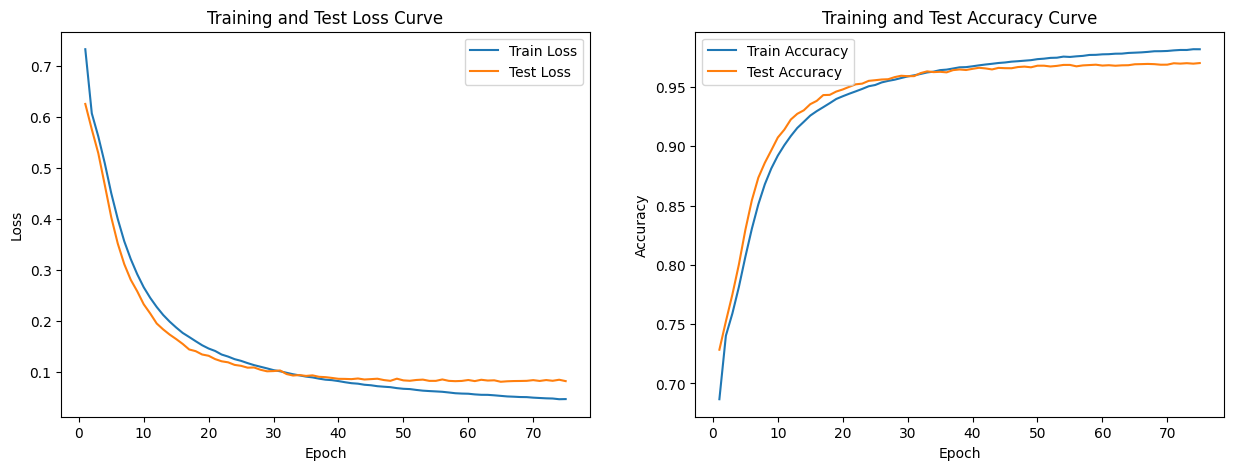

In [13]:
#Testing against the test dataset

model = Classifier(
                    n_features=len(cont_columns),
                    targets_classes=target_classes,
                    rff_on=True,
                   sigma=best_params['sigma'],
                   embed_size=best_params['embed_size'],
                   num_layers=best_params['num_layers'],
                   heads=best_params['heads'],
                   forward_expansion=best_params['forward_expansion'],
                   pre_norm_on=best_params['prenorm_on'],
                   mlp_scale_classification=best_params['mlp_scale_classification'],
                   embedding_dropout=best_params['embedding_dropout'],
                   decoder_dropout=best_params['decoder_dropout'],
                   classification_dropout=best_params['class_drop']
                   ).to(device_in_use) # Instantiate the model
loss_functions = UncertaintyLoss(1)
optimizer = torch.optim.Adam(params=model.parameters(), lr = best_params['learning_rate']) # Maybe try messing around with optimizers. try other torch optimizers with different configurations.
early_stopping = EarlyStopping(patience=3)
epochs = 75 #Set the number of epochs

train_losses = []
train_accuracies_1 = [] 
train_accuracies_2 = []
train_recalls = [] 
train_f1_scores = [] 
test_losses = []
test_accuracies_1 = []
test_accuracies_2 = []
test_recalls = []  
test_f1_scores = [] 
all_attention_scores = []

for t in range(epochs):
  train_loss, train_accuracy_1 = train(train_dataloader, model, loss_functions, optimizer, device_in_use=device_in_use)
  test_loss, test_accuracy_1, all_predictions_1, all_targets_1, f1_1 = test(test_dataloader, model, loss_functions, device_in_use=device_in_use)
  train_losses.append(train_loss)
  train_accuracies_1.append(train_accuracy_1)
  # train_accuracies_2.append(train_accuracy_2)
  # train_recalls.append(train_recall) 
  # train_f1_scores.append(train_f1)
  test_losses.append(test_loss)
  test_accuracies_1.append(test_accuracy_1)
  # test_accuracies_2.append(test_accuracy_2)
  # test_recalls.append(test_recall)
  # test_f1_scores.append(test_f1)
  # Formatting for easier reading
  epoch_str = f"Epoch [{t+1:2}/{epochs}]"
  train_metrics = f"Train: Loss {format_metric(train_loss)}, Accuracy {format_metric(train_accuracy_1)}"
  test_metrics = f"Test: Loss {format_metric(test_loss)}, Accuracy {format_metric(test_accuracy_1)}, F1 {format_metric(f1_1)}"
  print(f"{epoch_str:20} | {train_metrics:65} | {test_metrics}")

  if early_stopping(test_accuracy_1):
    break

# Save the model after pre-training
torch.save(model.state_dict(), 'final_model_trained.pth')

# Plotting the loss curves
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, epochs+1), [l for l in test_losses], label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss Curve')
plt.legend()

# Plotting the accuracy curves
plt.subplot(1, 2, 2)
plt.plot(range(1, epochs+1), train_accuracies_1, label='Train Accuracy')
plt.plot(range(1, epochs+1), test_accuracies_1, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Test Accuracy Curve')
plt.legend()

# Display confusion matrix for the first task (Traffic Type) on test data
conf_matrix_1 = confusion_matrix(all_targets_1, all_predictions_1)
print("Confusion Matrix for income")
print(conf_matrix_1)
